# Imports

In [1]:
!pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html
!pip install transformers requests beautifulsoup4 pandas numpy
!pip install text2emotion

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████▌                  | 834.1 MB 1.4 MB/s eta 0:13:25tcmalloc: large alloc 1147494400 bytes == 0x561c7f7f4000 @  0x7fb335fed615 0x561c456384cc 0x561c4571847a 0x561c4563b2ed 0x561c4572ce1d 0x561c456aee99 0x561c456a99ee 0x561c4563cbda 0x561c456aed00 0x561c456a99ee 0x561c4563cbda 0x561c456ab737 0x561c4572dc66 0x561c456aadaf 0x561c4572dc66 0x561c456aadaf 0x561c4572dc66 0x561c456aadaf 0x561c4563d039 0x561c45680409 0x561c4563bc52 0x561c456aec25 0x561c456a99ee 0x561c4563cbda 0x561c456ab737 0x561c456a99ee 0x561c4563cbda 0x561c456aa915 0x561c4563cafa 0x561c456aac0d 0x561c456a99ee
     |█████████████████               | 1055.7 MB 52.2 MB/s eta 0:00:18tcmalloc: large alloc 1434370048 bytes == 0x561cc3e4a000 @  0x7fb335fed615 0x561c456384cc 0x561c4571847a 0x561c4563b2ed 0x561c4572ce1d 0x561c456aee99 0x561c456a99ee 0x561c4563cbda 0x561c456aed00 0x561c456a99ee 0x561c4563cbda 0x561c456ab737 0x561c4572dc66 0x561c456aa

In [53]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy

import text2emotion as te
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from google.colab import files
from datetime import datetime
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# DataFrame Loading

we load all the quotes preprocessed in the quote_extraction notebook

In [5]:
df_chevy = pd.read_json("/content/drive/MyDrive/quotes/Chevy-quotes-2015.json")
df_chevy = df_chevy.append(pd.read_json("/content/drive/MyDrive/quotes/Chevy-quotes-2016.json"))
df_chevy = df_chevy.append(pd.read_json("/content/drive/MyDrive/quotes/Chevy-quotes-2017.json"))
df_chevy = df_chevy.append(pd.read_json("/content/drive/MyDrive/quotes/Chevy-quotes-2018.json"))
df_chevy = df_chevy.append(pd.read_json("/content/drive/MyDrive/quotes/Chevy-quotes-2019.json"))
df_chevy = df_chevy.append(pd.read_json("/content/drive/MyDrive/quotes/Chevy-quotes-2020.json"))
df_chevy.reset_index(inplace=True)

df_tesla = pd.read_json("/content/drive/MyDrive/quotes/Tesla-quotes-2015.json")
df_tesla = df_tesla.append(pd.read_json("/content/drive/MyDrive/quotes/Tesla-quotes-2016.json"))
df_tesla = df_tesla.append(pd.read_json("/content/drive/MyDrive/quotes/Tesla-quotes-2017.json"))
df_tesla = df_tesla.append(pd.read_json("/content/drive/MyDrive/quotes/Tesla-quotes-2018.json"))
df_tesla = df_tesla.append(pd.read_json("/content/drive/MyDrive/quotes/Tesla-quotes-2019.json"))
df_tesla = df_tesla.append(pd.read_json("/content/drive/MyDrive/quotes/Tesla-quotes-2020.json"))
df_tesla.reset_index(inplace=True)

# NLP Pipeline

We define functions that will be of use when processing the data

In [6]:
def clean(text):

    text = re.sub('[^A-Za-z]+', ' ', text)
    return text

def listToString(s): 
  
    str1 = " " 
    return (str1.join(s))

def processing(reviews):

  tokenized = []
  stop_rmvd_string = []

  for sentence in reviews:
    
    tokens = [token.text for token in nlp(sentence)]
    tokenized.append(tokens)
    
    stop_words = [token.text for token in nlp(sentence) if not token.is_stop]
    stop_rmvd_string.append(listToString(stop_words))

  return tokenized, stop_rmvd_string

nlp = spacy.load('en')



We perform tokeniation and stopword removal as step for NLP processing 

In [7]:
df_tesla['Cleaned Reviews'] = df_tesla['quotation'].apply(clean)

tesla_tokenized, tesla_rmvd_string = processing(df_tesla["Cleaned Reviews"])
df_tesla['Tokenized'] = tesla_tokenized
df_tesla['Stop Words Removed'] = tesla_rmvd_string


df_chevy['Cleaned Reviews'] = df_chevy['quotation'].apply(clean)

chevy_tokenized, chevy_rmvd_string = processing(df_chevy["Cleaned Reviews"])
df_chevy['Tokenized'] = chevy_tokenized
df_chevy['Stop Words Removed'] = chevy_rmvd_string

# VADER Analysis

We define the function that will perform the VADER analysis on each quote for both cases, who uses a sentiment lexicon to weigth the positiveness of the word in the sentence in order to output a value 

In [20]:
nltk.download('vader_lexicon')

def vadersentimentanalysis(review):

    vs = analyzer.polarity_scores(review)
    return vs['compound']

analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [21]:
df_tesla['Vader_Sentiment'] = df_tesla['Stop Words Removed'].apply(vadersentimentanalysis)
df_chevy['Vader_Sentiment'] = df_chevy['Stop Words Removed'].apply(vadersentimentanalysis)

# BERT Analysis

Perform the analysis using BERT, the pre-trained sentiment analysis tranformer based neural network

In [22]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/953 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/638M [00:00<?, ?B/s]

This function will output the review score of BERT, which goes from 1 to 5

In [23]:
def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [24]:
df_tesla['review'] = df_tesla['quotation'].apply(lambda x: sentiment_score(x[:512]))
df_chevy['review'] = df_chevy['quotation'].apply(lambda x: sentiment_score(x[:512]))

# Text 2 Emotion Analyis

We perform the last sentiment analysis algorithm, Text2Emotion, who maps a sentiement based on the sentence given

In [25]:
def high_emotion(d):

     v=list(d.values())
     k=list(d.keys())
     return k[v.index(max(v))]
     

In [26]:
df_tesla['Text 2 Emotion'] = df_tesla['Stop Words Removed'].apply(te.get_emotion)
df_tesla['Emotion'] = df_tesla['Text 2 Emotion'].apply(high_emotion)

df_chevy['Text 2 Emotion'] = df_chevy['Stop Words Removed'].apply(te.get_emotion)
df_chevy['Emotion'] = df_chevy['Text 2 Emotion'].apply(high_emotion)

# Emotion Verification

We now perform the emotion checking step, where we will compare the different outputs of the sentiment analysis algorithms, in order to correct the VADER score should the other two techniques output contrary results 

In [27]:
def vibe_check(vibe_BERT, vibe_VADER, vibe_t2e):

  vibe_curr = vibe_VADER

  if vibe_BERT == 1 or vibe_VADER == 2:
    if (vibe_VADER > 0.6) and (vibe_t2e == "Happy" or vibe_t2e == "Surprised"):
      vibe_curr = 0.7

  elif vibe_BERT == 4 or vibe_BERT == 5:
    if (vibe_VADER < 0.4) and (vibe_t2e == "Sad" or vibe_t2e == "Fear"):
      vibe_curr = 0.3
  
  return vibe_curr

In [28]:
df_tesla['Vibe Checked'] = df_tesla.apply(lambda row: vibe_check(row['review'], row['Vader_Sentiment'], row['Text 2 Emotion']), axis=1)
df_chevy['Vibe Checked'] = df_chevy.apply(lambda row: vibe_check(row['review'], row['Vader_Sentiment'], row['Text 2 Emotion']), axis=1)

# Selecting Frequent Speakers

Counting how much people talk and what is their overall sentiement by counting how much quotes were labeled as positive or negative 

In [31]:
def emotion_count(dataframe):

  speakers = dataframe["qids"].drop_duplicates().tolist()

  pos_count = []
  neg_count = []
  neu_count = []
  tot_count = []

  speakers_group = dataframe.groupby("qids")

  for curr in speakers:
          
      analysis = speakers_group.get_group(curr)["review"]
      vals = Counter(analysis)
      pos_count.append(vals[5] + vals[4])
      neg_count.append(vals[1] + vals[2])
      neu_count.append(vals[3])
      tot_count.append(vals[1] + vals[2] + vals[3] + vals[4] + vals[5])
          
  emotion_count = pd.DataFrame()
  emotion_count["Speakers"] = speakers
  emotion_count["Positive Count"] = pos_count
  emotion_count["Negative Count"] = neg_count
  emotion_count["Neutral Count"] = neu_count
  emotion_count["Total Count"] = tot_count

  return emotion_count

We look at who talked to most and select the speakers who talked at least 5 times to have meaningful evolutions

In [32]:
emotion_count_tesla = emotion_count(df_tesla)
most_cited = emotion_count_tesla[emotion_count_tesla["Total Count"] > 5]
most_cited_speakers = most_cited["Speakers"]
df_cited_tesla = df_tesla[df_tesla["qids"].isin(most_cited_speakers)]

In [33]:
emotion_count_chevy = emotion_count(df_chevy)
most_cited = emotion_count_chevy[emotion_count_chevy["Total Count"] > 5]
most_cited_speakers = most_cited["Speakers"]
df_cited_chevy = df_chevy[df_chevy["qids"].isin(most_cited_speakers)]

# Load Relevant Supplementary Data

We load the data that was extracted when processing the data to gather all the information we have about the speakers

In [36]:
from_qids_to_label_occupation = pd.read_json('/content/drive/MyDrive/speaker_attributes/occupations.json') 
from_qids_to_label_ethnics = pd.read_json('/content/drive/MyDrive/speaker_attributes/ethnic.json' ) 
from_qids_to_label_religion = pd.read_json('/content/drive/MyDrive/speaker_attributes/religion.json') 
from_qids_to_label_nationality = pd.read_json('/content/drive/MyDrive/speaker_attributes/nationality.json') 
from_qids_to_label_party = pd.read_json('/content/drive/MyDrive/speaker_attributes/party.json') 
from_qids_to_label_gender = pd.read_json('/content/drive/MyDrive/speaker_attributes/gender.json') 

df_speakers_attributes = pd.read_parquet('/content/drive/MyDrive/speaker_attributes/speaker_attributes.parquet')

# Map Speaker Attributes

In [37]:
def map_qids_labels(list_qids,df_):
    """Transform a list of QIDS into a list of labels, return 0 if the list is empty (which is equal to 0 in the dataframe)."""
    if(type(list_qids)!=int):
        return [df_[df_.qids == x].values[0][1] for x in list_qids if (x!=0 and len(df_[df_.qids == x].values) != 0)]    
    else:
        return 0  

def process_speakers_attributes(df_speakers_attributes):
    """Add the columns for the party, occupation, religion, ethnics and nationality their labels. Take as input the dataframe with the selected speakers and return the same dataframe with the columns added."""
    df = df_speakers_attributes[['date_of_birth','nationality','gender','ethnic_group','occupation','id','label','religion','party']]
    df = df.rename(columns={'date_of_birth':'birth','nationality':'nationality_qids','gender':'gender_qids','ethnic_group':'ethnics_qids','occupation':'occupations_qids','id':'name_qids','label':'name_label','religion':'religion_qids','party':'party_qids','gender':'gender_qids'})
    # Add labels for occupations, ethincs, religion, nationality, party
    df = df.fillna(0)
    df['occupation_label']= df['occupations_qids'].apply(lambda x : map_qids_labels(x,from_qids_to_label_occupation))
    df['ethnics_label']= df['ethnics_qids'].apply(lambda x : map_qids_labels(x,from_qids_to_label_ethnics))
    df['religion_label']= df['religion_qids'].apply(lambda x : map_qids_labels(x,from_qids_to_label_religion))
    df['nationality_label']= df['nationality_qids'].apply(lambda x : map_qids_labels(x,from_qids_to_label_nationality))
    df['party_label']= df['party_qids'].apply(lambda x : map_qids_labels(x,from_qids_to_label_party))
    df['gender_label']= df['gender_qids'].apply(lambda x : map_qids_labels(x,from_qids_to_label_gender))
    return df


In [38]:
def select_speakers(list_qids):
  
    """From a list of QIDS of speakers, return the dataframe with only the speakers that are in the list."""
    return df_speakers_attributes[df_speakers_attributes.id.isin(list_qids)]

def process_dataframe_quotes(df_sent, time_range, speakers, explode_by):
    """ Transform the date into a datetime object ('%Y-%m-%d %H:%M:%S)
        Split with the time_range the dataframe df. Add a columns 'period' with the label before, during or after. 
        Join the quotes dataframe with the speakers dataframe on the name_qids.
        Explode the dataframe depending on the column(s) in explode_by"""
    
    # Rename the columns and keep only the one needed
    df_sent = df_sent.rename(columns={'qids':'name_qids','quoteID':'quote_qids','Emotion':'emotion'})
    df_sent = df_sent[['date','name_qids','quotation','quote_qids','Vader_Sentiment','emotion','review']]
    # Change timestamp in datetime object and add the perdio depending on the time_range list
    df_sent['date']= df_sent['date'].apply(lambda x :datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S'))
    df_sent['year_month']= df_sent['date'].apply(lambda x :datetime.strptime(str(x)[:7], '%Y-%m'))
    
    #df_sent['period'] = df_sent['date'].apply(lambda x : select_period(x,time_range))
    
    #Join the dataframe with the speakers attributes on the name_qids
    df = df_sent.merge(speakers, on='name_qids')

    # Explode the df by the column(s) in explode_by
    #df = df.explode(explode_by)
    
    return df

In [39]:
list_qids = df_tesla.drop_duplicates(['qids']).qids.values
df_tesla_ = select_speakers(list_qids)
df_speakers_att_tesla = process_speakers_attributes(df_tesla_)

In [40]:
list_qids = df_chevy.drop_duplicates(['qids']).qids.values
df_chevy_ = select_speakers(list_qids)
df_speakers_att_chevy = process_speakers_attributes(df_chevy_)

# Process Dates

In [41]:
start = datetime.strptime(str('2017-07-28 00:00:00'), '%Y-%m-%d %H:%M:%S')
end = datetime.strptime(str('2017-07-28 23:59:59'), '%Y-%m-%d %H:%M:%S')
time_range = [start,end]
speakers = df_speakers_att_tesla[['name_qids','name_label','occupations_qids','occupation_label','nationality_label']]
explode_by = 'occupations_qids'
df_tesla = process_dataframe_quotes(df_tesla, time_range, speakers, explode_by)

We process the dates of the quotes and the attributes that interest us for further analyses 

In [42]:
start = datetime.strptime(str('2017-07-28 00:00:00'), '%Y-%m-%d %H:%M:%S')
end = datetime.strptime(str('2017-07-28 23:59:59'), '%Y-%m-%d %H:%M:%S')
time_range = [start,end]
speakers = df_speakers_att_chevy[['name_qids','name_label','occupations_qids','occupation_label','nationality_label']]
explode_by = 'occupations_qids'
df_chevy = process_dataframe_quotes(df_chevy, time_range, speakers, explode_by)

In [44]:
df_tesla.to_json('Tesla_Sentiment_Complete.json')
files.download('/content/Tesla_Sentiment_Complete.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [45]:
df_chevy.to_json('Chevy_Sentiment_Complete.json')
files.download('/content/Chevy_Sentiment_Complete.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

We define a function that will build wordclouds in order to visualize the most frequent occurences of various words

In [54]:
def wordcloud_plot(var_vector, mask = None):

  var_vector_exp = var_vector.explode().tolist()
  var_vector_exp = [str(val) for val in var_vector_exp]

  f = plt.figure()
  f.set_figwidth(30)
  f.set_figwidth(12)

  wc = WordCloud(background_color="white", contour_width=3, contour_color='steelblue', mask = mask)
  wc.generate(listToString(var_vector_exp))
  plt.imshow(wc, interpolation='bilinear', cmap=plt.cm.gray)
  plt.axis("off")

mask = np.array(Image.open("vroum_autre.jpg"))

# Occupations

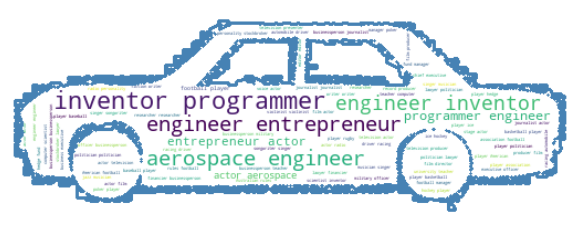

In [56]:
wordcloud_plot(df_tesla["occupation_label"], mask = mask)

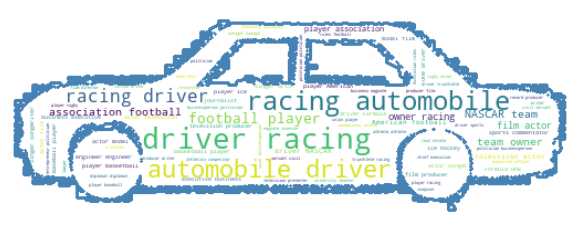

In [58]:
wordcloud_plot(df_chevy["occupation_label"], mask = mask)

# Nationalities

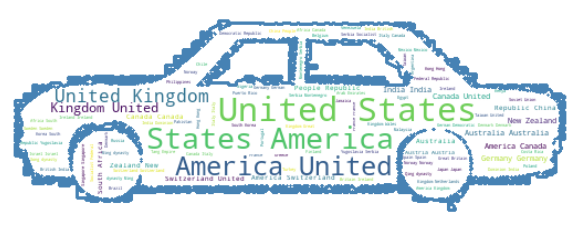

In [62]:
no_musk = df_tesla[df_tesla["name_label"] != "Elon Musk"]
wordcloud_plot(no_musk["nationality_label"], mask = mask)

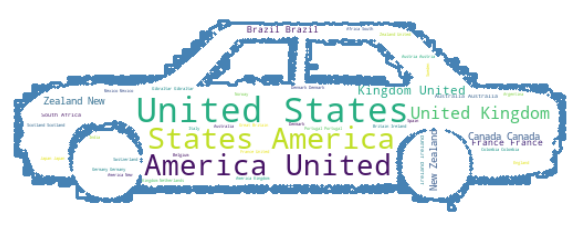

In [61]:
wordcloud_plot(df_chevy["nationality_label"], mask = mask)